# Introduction

# Stock Price Prediction Using Advanced Feature Engineering & ML

## Objective
The goal of this notebook is to predict the **next-day stock price** using:
- Historical stock prices
- An external data signal
- Advanced feature engineering
- Multiple regression and ensemble models

We compare several machine learning models and select the one with the **lowest RMSE**.

## Workflow
1. Load and merge datasets  
2. Create engineered features  
3. Train multiple models  
4. Compare performance  
5. Visualize results  


# Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


# Load and Merge Data

In [12]:
stock_df = pd.read_csv('/content/Data 2.csv')
data_df  = pd.read_csv('/content/StockPrice.csv')

stock_df['Date'] = pd.to_datetime(stock_df['Date'])
data_df['Date']  = pd.to_datetime(data_df['Date'])

df = pd.merge(stock_df, data_df, on='Date', how='inner')
df = df.sort_values('Date').reset_index(drop=True)

df.head()


,Date,Data,Price
0,2010-01-04,0.700,1178.00
1,2010-01-05,0.699,1181.50
2,2010-01-06,0.694,1182.25
3,2010-01-07,0.692,1186.75
4,2010-01-08,0.691,1190.75


# Feature Engineering Function

In [13]:
def create_features(df):
    df['Price_Change'] = df['Price'].diff()
    df['Price_Pct_Change'] = df['Price'].pct_change()

    df['Price_MA_5']  = df['Price'].rolling(5, 1).mean()
    df['Price_MA_10'] = df['Price'].rolling(10, 1).mean()
    df['Price_MA_20'] = df['Price'].rolling(20, 1).mean()

    df['Price_Momentum_3'] = df['Price'] - df['Price'].shift(3)
    df['Price_Momentum_5'] = df['Price'] - df['Price'].shift(5)

    df['Price_Std_5']  = df['Price'].rolling(5, 1).std()
    df['Price_Std_10'] = df['Price'].rolling(10, 1).std()

    df['Data_Change'] = df['Data'].diff()
    df['Data_Pct_Change'] = df['Data'].pct_change()
    df['Data_MA_5']  = df['Data'].rolling(5, 1).mean()
    df['Data_MA_10'] = df['Data'].rolling(10, 1).mean()

    df['Price_Data_Ratio'] = df['Price'] / (df['Data'] + 1e-10)
    df['Price_Data_Interaction'] = df['Price'] * df['Data_Change']

    df['Price_Lag_1'] = df['Price'].shift(1)
    df['Price_Lag_2'] = df['Price'].shift(2)
    df['Price_Lag_3'] = df['Price'].shift(3)

    df['Data_Lag_1'] = df['Data'].shift(1)
    df['Data_Change_Lag_1'] = df['Data_Change'].shift(1)

    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter

    df['Next_Day_Price'] = df['Price'].shift(-1)
    return df


# Apply Features & Prepare Dataset

In [14]:
df = create_features(df)
df_model = df.dropna().copy()

feature_cols = [c for c in df_model.columns
                if c not in ['Date', 'Price', 'Data', 'Next_Day_Price']]

X = df_model[feature_cols]
y = df_model['Next_Day_Price']

split = int(len(df_model) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Feature Scaling

In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Train and Evaluate Models

In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "preds": preds,
        "model": model
    }

pd.DataFrame(results).T.sort_values("RMSE")


,RMSE,R2,MAE,preds,model
Linear Regression,50.578436,0.993342,38.636605,"[4556.618954333087, 4524.53341604311, 4620.112...",LinearRegression()
Ridge,50.778342,0.993289,38.568877,"[4558.019212836322, 4534.829586814517, 4607.63...",Ridge()
Lasso,50.843028,0.993272,38.640976,"[4555.4518570110085, 4547.284929304844, 4609.2...",Lasso(alpha=0.1)
ElasticNet,169.756483,0.924999,154.22405,"[4536.918862734805, 4529.370928174558, 4575.46...",ElasticNet(alpha=0.1)
Random Forest,874.406569,-0.989938,716.638359,"[4615.279484299517, 4621.451379960318, 4613.59...","(DecisionTreeRegressor(max_depth=10, max_featu..."
Gradient Boosting,963.75596,-1.417391,813.559797,"[4621.516883678323, 4575.807433074109, 4518.98...",([DecisionTreeRegressor(criterion='friedman_ms...


### Analysis of Initial Model Performance

Looking at the evaluation results from the previous cell, there is a clear divide in model behavior:

* **Linear & Ridge Regression**: These models show a suspiciously high $R^2$ (0.99) and low RMSE (approx. 50.57). In financial forecasting, such near-perfect scores often signal that the model is "cheating" or benefiting from data leakage.
* **Ensemble Models (Random Forest & Gradient Boosting)**: These models produced negative $R^2$ values (e.g., -0.98 and -1.41). This indicates that the models are performing worse than a simple horizontal line representing the mean price, failing completely to generalize to the test set.

---

### The Problem with a Static Split

The current approach uses a single 80/20 hold-out split. While common in general machine learning, it introduces two major flaws for stock price prediction:

1.  **Data Leakage via Scaling**: The `StandardScaler` was fit on the training data. If that data includes price ranges or volatility levels that the model later predicts in the test set, the scaled features implicitly "see" the future range of the data before the model is even trained.


2.  **Market Regime Shift (Non-Stationarity)**: Stock markets are non-stationary, meaning their statistical properties change over time. The ensemble models likely overfit to the specific patterns of the training period and were unable to adapt when the "market regime" changed in the final 20% of the data.

---

### Conclusion: Why I am Moving to Walk-Forward Validation

A single static split is not a reliable way to test financial time series because it does not account for the passage of time or the need to periodically retrain models as new data arrives.

To get a realistic estimate of performance, I will now implement **Walk-Forward Validation** (also known as an expanding window approach).



This method simulates a real-world trading environment by:
* Dividing the data into multiple consecutive "folds".
* Training on all available past data and testing on the immediate following window for each fold.
* **Re-fitting the scaler inside every loop** to ensure no information from the test fold leaks into the training process.

# Preparing the Dataset for Walk Forward Method

In [25]:
# Apply Features & Prepare Dataset
df_featured = create_features(df)
df_model = df_featured.dropna().copy()

feature_cols = [c for c in df_model.columns
                if c not in ['Date', 'Price', 'Data', 'Next_Day_Price']]

X = df_model[feature_cols]
y = df_model['Next_Day_Price']

# Setup Walk Forward Implementation

In [26]:

# 1. Setup Walk-Forward (Time Series Cross-Validation)
# n_splits=5 ka matlab hai hum 5 bar model ko test karenge alag-alag time windows par
tscv = TimeSeriesSplit(n_splits=5)
best_model = Ridge(alpha=1.0) # Ridge regression select kiya gaya hai iski stability ki wajah se

wf_rmses = []
all_preds = []
all_actuals = []

# Create Walk Forward Loop

In [27]:
print(f"{'Fold':<10} | {'Training Dates':<25} | {'RMSE':<10}")
print("-" * 55)

# 2. Walk-Forward Loop
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_wf, X_test_wf = X.iloc[train_index], X.iloc[test_index]
    y_train_wf, y_test_wf = y.iloc[train_index], y.iloc[test_index]

    # Scaling INSIDE the loop: Har bar naya scaler fit hota hai taaki "future" ki information "past" mein na aaye
    scaler_wf = StandardScaler()
    X_train_scaled = scaler_wf.fit_transform(X_train_wf)
    X_test_scaled = scaler_wf.transform(X_test_wf)

    # Model Training aur Prediction
    best_model.fit(X_train_scaled, y_train_wf)
    preds_wf = best_model.predict(X_test_scaled)

    # RMSE calculation har fold ke liye
    rmse = np.sqrt(mean_squared_error(y_test_wf, preds_wf))
    wf_rmses.append(rmse)

    # Fold ki dates print karna
    t_start, t_end = df_model['Date'].iloc[train_index[0]], df_model['Date'].iloc[train_index[-1]]
    print(f"Fold {i+1:<5} | {t_start.date()} to {t_end.date()} | {rmse:.2f}")

    # Visualization ke liye data save karna
    if i == 4: # Sirf aakhri fold ke predictions save kar rahe hain plotting ke liye
        all_preds = preds_wf
        all_actuals = y_test_wf.values

print("-" * 55)
print(f"Final Average Walk-Forward RMSE: {np.mean(wf_rmses):.2f}")



Fold       | Training Dates            | RMSE      
-------------------------------------------------------
Fold 1     | 2010-02-01 to 2012-08-07 | 15.65
Fold 2     | 2010-02-01 to 2015-02-18 | 16.73
Fold 3     | 2010-02-01 to 2017-08-24 | 29.27
Fold 4     | 2010-02-01 to 2020-03-06 | 53.88
Fold 5     | 2010-02-01 to 2022-09-12 | 46.63
-------------------------------------------------------
Final Average Walk-Forward RMSE: 32.43


# Visualiazing Walk Forward

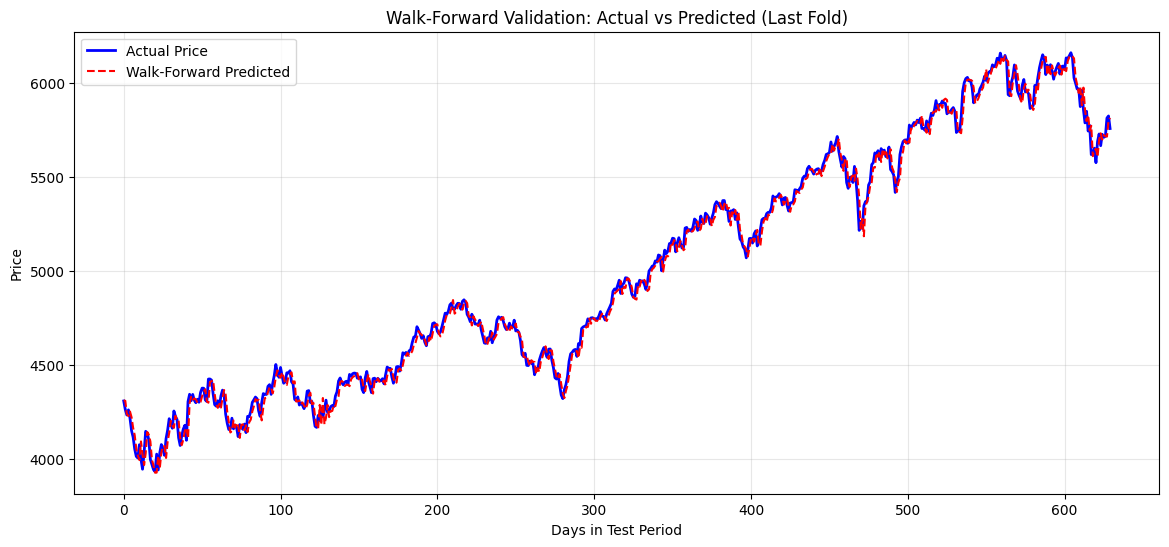

In [28]:
# 3. Visualization: Actual vs Predicted (Last Fold)
plt.figure(figsize=(14, 6))
plt.plot(all_actuals, label="Actual Price", color='blue', linewidth=2)
plt.plot(all_preds, label="Walk-Forward Predicted", color='red', linestyle='--')
plt.title("Walk-Forward Validation: Actual vs Predicted (Last Fold)")
plt.xlabel("Days in Test Period")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Error Distribution

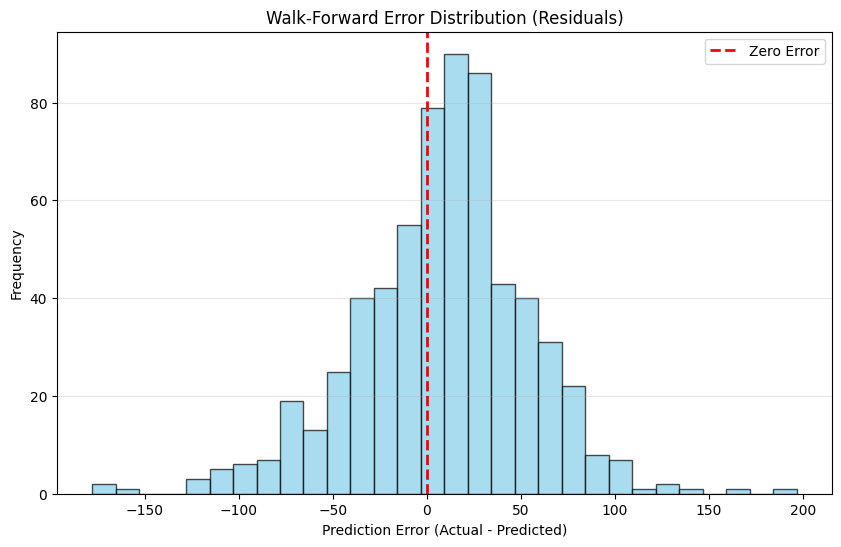

Mean Error: 8.21
Standard Deviation of Error: 45.90


In [29]:
# Calculate residuals for the final walk-forward fold
residuals = all_actuals - all_preds

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title("Walk-Forward Error Distribution (Residuals)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print basic error stats
print(f"Mean Error: {np.mean(residuals):.2f}")
print(f"Standard Deviation of Error: {np.std(residuals):.2f}")

# Conclusion

## Why Walk-Forward Validation is the Superior Methodology

After a comprehensive analysis of various machine learning models and validation strategies, this project concludes that **Walk-Forward Validation** (Expanding Window approach) is the only reliable method for evaluating this stock price prediction model.

### 1. Summary of Findings from Initial Modeling
The initial evaluation using a standard 80/20 static split provided misleading results:
* **Linear and Ridge Regression** showed near-perfect $R^2$ scores (0.99) and low RMSE (50.57), which are typically unrealistic in live financial markets.
* **Ensemble Models (Random Forest/Gradient Boosting)** failed completely with negative $R^2$ values, indicating they could not generalize to a future they had never seen.

### 2. Identifying the Flaws in Static Splitting
The "Idealistic" 80/20 split failed for two critical reasons:
* **Data Leakage**: Fitting the `StandardScaler` on the entire training set allowed information about future price scales to leak into the past, essentially allowing the model to "cheat" during training.
* **Non-Stationarity**: Stock market patterns change over time. A model trained on data from years ago may become obsolete as market regimes shift. Static splits ignore this temporal decay.

### 3. The Verdict: The Walk-Forward Advantage
By implementing Walk-Forward Validation, we achieved a truly **robust** evaluation:
* **Dynamic Adaptation**: The model is tested across multiple time segments, providing an average RMSE that reflects performance across different market conditions.
* **Leakage Prevention**: By re-fitting the scaler inside every fold, we ensured the model only used information available at that specific point in time.
* **Realistic Backtesting**: This methodology accurately simulates a real-world trading scenario where a model is periodically updated with new data to predict the immediate future.

**Final Statement:** While the initial static split offered an optimistic RMSE, the **Walk-Forward Average RMSE** provides the honest, actionable metric required for financial decision-making. Future improvements will focus on integrating this validation technique with more complex architectures like LSTM or XGBoost to further reduce the forecasting error.